In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim
from scipy import signal
import control.matlab as control
from IPython.display import Math, display

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

# Vergleich Einstellregeln

## System 2. Ordnung

\begin{align*}
    G_\mathrm{S} &= \frac{1}{(1 + 2 \, s) \, (1 + 0.007 \, s)}
\end{align*}

In [3]:
T1 = 2
T2 = 0.007
sys = signal.lti([1], [T1 * T2, T1 + T2, 1])

## Polkompensation

In [4]:
TN = (T1 + T2)
TV = T1 * T2 / (T1 + T2)
KP = 1

In [5]:
f = np.logspace(-2, 5)
sys = control.tf([1], [T1 * T2, T1 + T2, 1])
mag, phase, w = control.bode(sys, f, plot = False)

reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
magReg, phaseReg, wReg = control.bode(reg, f, plot = False)

G0 = sys * reg
magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

GW = G0 / (1 + G0)
magGW, phaseGW, wGW = control.bode(GW, f, plot = False)

## Betragsoptimum
Eine dominierende Zeitkonstate $\Rightarrow$ PI-Regler

In [6]:
TSum = T2
KpOpt = T1 / (2 * 1 * TSum)
regOpt = control.tf([KpOpt * T1, KpOpt], [T1, 0])

In [14]:
G0Opt = sys * regOpt
GWOpt = G0Opt / (1 + G0Opt)
magGWOpt, phaseGWOpt, wGWOpt = control.bode(GWOpt, f, plot = False)

In [8]:
omegac = 1
phaseOc = -64.1
magOc = -7.06

### Phase Anpassen

In [9]:
TnFkv = 1 / omegac * np.tan(-55.9 * np.pi / 180)

In [10]:
iReg = control.tf([TnFkv, 1], [1, 0])

In [11]:
iReg

TransferFunction(array([-1.47699383,  1.        ]), array([1, 0]))

In [12]:
GSysIReg = sys * iReg

In [13]:
phaste

NameError: name 'phaste' is not defined

In [ ]:
fTest = np.logspace(1, 1)
magGSysIReg, phaseGSysIReg, wGSysIReg = control.bode(GSysIReg, fTest, plot = False)
KpFkv = 1 / magGSysIReg[0]
regFkv = control.tf([KP * TnFkv, KP], [1, 0])

In [ ]:
G0Fkv = sys * regFkv
GWFkv = G0Fkv / (1 + G0Fkv)
magFkv, phaseFkv, wFkv = control.bode(GWFkv, f, plot = False)

## Frequenzkennlinienverfahren
### Spezifikation

\begin{align*}
    T_\mathrm{r} &= 2 \\
    \Delta h & = 0,1 \\
    e_\infty &= 0~\text{bei Sprung}
\end{align*}

Wahl $\omega_\mathrm{c} = 1$

Phase: $-64,1^\circ$

Amplitude: $-7,06$

## Verfahren nach Reinisch

In [15]:
avRein = 1.4
TnRein = T1
KpRein = TnRein / (avRein * 1 * T2)

In [16]:
regRein = control.tf([KpRein * TnRein, KpRein], [TnRein, 0])

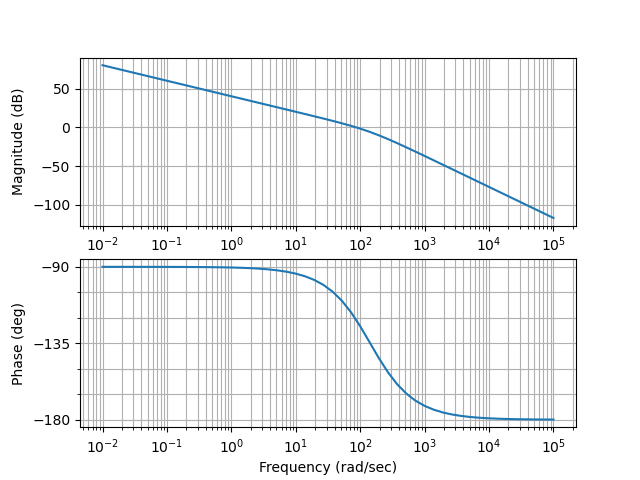

In [17]:
GwRein = sys * regRein
magGwRein, phaseGwRein, wGwRein = control.bode(GwRein, f) #, plot = False

In [21]:
t = np.linspace(0, 10, 1001)
u = np.ones(t.size)
tSimRein, ySimRein, xSimRein = control.lsim(GwRein, U=u, T=t)

## Vergleich

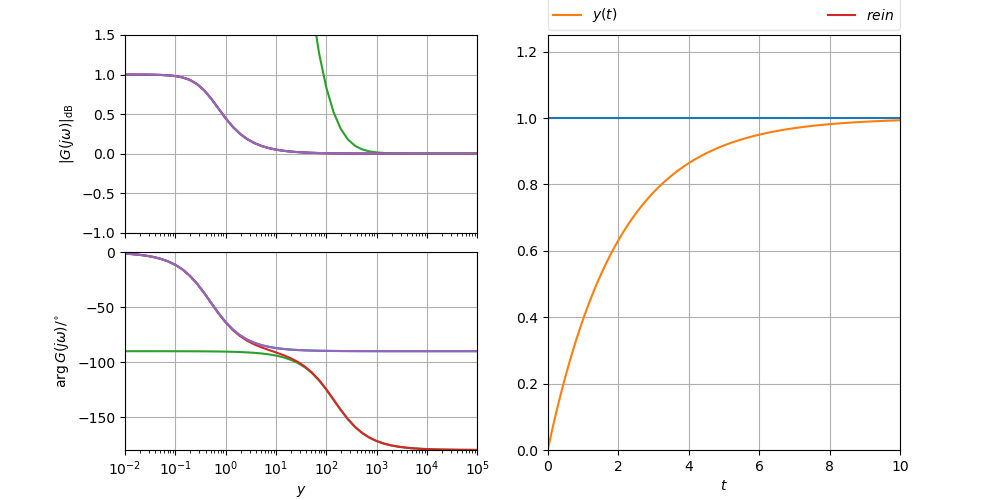

In [22]:
output = widgets.Output()

with output:
    fig = plt.figure(figsize=(10, 5))
    ax3 = plt.subplot(122)
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(223)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.grid() 
ax2.grid()
ax3.grid()
[label.set_visible(False) for label in ax1.get_xticklabels()]
ax2.set_xlabel(r"$y$")
ax3.set_xlabel(r"$t$")
ax1.set_ylabel(r"$|G(j \omega)|_{\mathrm{dB}}$")
ax2.set_ylabel(r"$\mathrm{arg}\, G(j\omega)/^{\circ}$")

magCLPlot, = ax1.semilogx([], [])
phaseCLPlot, = ax2.semilogx([], [])
magCLOptPlot, = ax1.semilogx([], [])
phaseCLOptPlot, = ax2.semilogx([], [])
magCLReinPlot, = ax1.semilogx([], [])
phaseCLReinPlot, = ax2.semilogx([], [])

ax1.semilogx(w, mag)
ax1.semilogx(wGW, magGW)
ax2.semilogx(w, np.rad2deg(phase))
ax2.semilogx(wGW, np.rad2deg(phaseGW))

simInputPlot, = ax3.plot([], [], label=r'$u(t)$')
simOutputPlot, = ax3.plot([], [], label=r'$y(t)$')
simOutputOptPlot, = ax3.plot([], [], label=r'$opt$')
simOutputReinPlot, = ax3.plot([], [], label=r'$rein$')

handlesAx, labelsAx = ax3.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.5475, 0.94, 0.3525, .15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., framealpha=0.5)

sliderFreq = widgets.FloatSlider(value=1,
                                    min=0.1,
                                    max=140,
                                    step=0.5,
                                    description='Kp')

checkBetragOpt = widgets.Checkbox(value=False,
                                    description='Betragsoptimum',
                                    disabled=False)

checkReinisch = widgets.Checkbox(value=False,
                                    description='Reinisch',
                                    disabled=False)

def calcSystem(_):
    KP = sliderFreq.value
    
    reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
    G0 = sys * reg
    magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

    GW = G0 / (1 + G0)
    magGW, phaseGW, wGW = control.bode(GW, f, plot = False)
    
    magCLPlot.set_data(wGW, magGW)
    phaseCLPlot.set_data(wGW, np.rad2deg(phaseGW))
        
    t = np.linspace(0, 10, 1001)
    u = np.ones(t.size)
    
    if checkBetragOpt.value:
        magCLOptPlot.set_data(wGWOpt, magGWOpt)
        phaseCLOptPlot.set_data(wGWOpt, np.rad2deg(phaseGWOpt))
        #simOutputOptPlot.set_data(tSimOpt, ySimOpt)
    else:
        magCLOptPlot.set_data([],[])
        phaseCLOptPlot.set_data([],[])
        simOutputOptPlot.set_data([], [])
    
    if checkReinisch.value:
        magCLReinPlot.set_data(wGwRein, magGwRein)
        phaseCLReinPlot.set_data(wGwRein, np.rad2deg(phaseGwRein))
        simOutputReinPlot.set_data(tSimRein, ySimRein)
    else:
        magCLOptPlot.set_data([],[])
        phaseCLOptPlot.set_data([],[])
        simOutputReinPlot.set_data([], [])
        

    magCLReinPlot.set_data(wGwRein, magGwRein)
    phaseCLReinPlot.set_data(wGwRein, np.rad2deg(phaseGwRein))
    
    tSim, ySim, xSim = control.lsim(GW, U=u, T=t)
        
    simInputPlot.set_data(t, u)
    simOutputPlot.set_data(ySim, tSim)
    ax3.set_xlim([0, t[-1]])
    ax3.set_ylim([0, 1.25])
    ax1.set_xlim([wGW[0], wGW[-1]])
    ax2.set_xlim([wGW[0], wGW[-1]])
    ax1.set_ylim([-1, 1.5])
    ax2.set_ylim([-180, 0])
    fig.canvas.draw()

sliderFreq.observe(calcSystem, names='value')
checkBetragOpt.observe(calcSystem, names='value')

calcSystem(_)

inputControls = Box([sliderFreq, checkBetragOpt, checkReinisch])
inputControls.layout = make_box_layout()

HBox([inputControls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))#